In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

### Week 3: Histopathologic Cancer Detection

#### Problem:
This project involves analyzing medical images and building a good CNN model to identify images showing symptoms of metastatic cancer. The data is sourced from https://www.kaggle.com/c/histopathologic-cancer-detection/overview, which itself is a slightly modified version of the PatchCamelyon dataset (supposedly with duplicates removed). The dataset is fairly large, with about 220,000 images in the training data (and another 57.5k for the test set). The training data comes with labels (for whether there is metastatic cancer).

#### EDA:
Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

Starting with importing the training labels into a dataframe. Label data is pretty straightforward, 220,025 entries, with an id as well as the actual label (0 for no cancer, 1 for with cancer).

In [12]:
label_df = pd.read_csv('histopathologic-cancer-detection/train_labels.csv', dtype=str)

print(label_df.info())
print(label_df.columns)
label_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB
None
Index(['id', 'label'], dtype='object')


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Checking for null values or duplicate rows. The Kaggle mentions duplicates were removed, but want to make sure. Doesn't seem like there's any missing or duplicated values though, so not much to clean.

In [13]:
# Check for null
na_count = label_df.isna().sum()
print("Null count:", na_count)

# Check for dupes
dupes = label_df['id'].duplicated()
print("Duplicate rows: ", dupes.sum())

Null count: id       0
label    0
dtype: int64
Duplicate rows:  0


I want to check the distribution of images labeled 0 and 1 to see if it's imbalanced. Overall, there's more 0s than 1s, but it's not overly imbalanced.

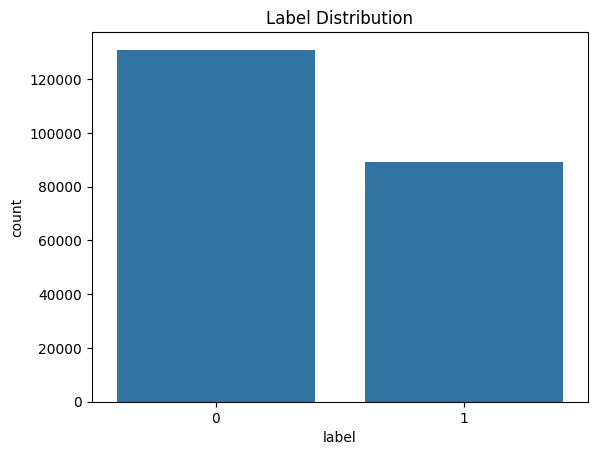

In [4]:
# Draw 0/1 label plot
sns.countplot(x='label', data=label_df)
plt.title('Label Distribution')
plt.show()

Showing some example images for reference. Also taking a look at image sizes, all images seem to be 96x96, which is good to know so I know what size input I'll need for the models.

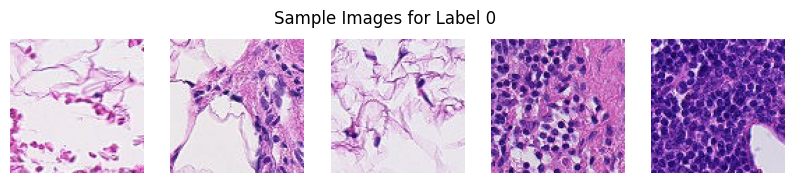

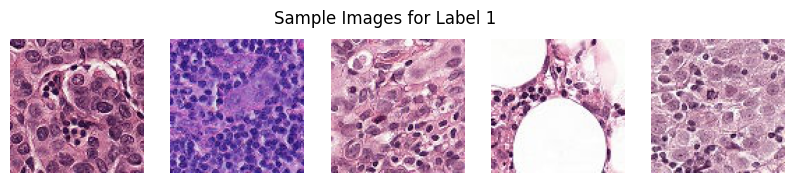

Image Sizes:  [(96, 96), (96, 96), (96, 96), (96, 96), (96, 96), (96, 96), (96, 96), (96, 96), (96, 96), (96, 96)]


In [24]:
train_image_path = ('histopathologic-cancer-detection/train/')
test_image_path = ('histopathologic-cancer-detection/test/')

sizes = []

def sample_images(label, num_samples=3):
    sample_images = label_df[label_df['label'] == str(label)].sample(num_samples)
    plt.figure(figsize=(10, 2))
    
    for i, img_name in enumerate(sample_images['id']):
        img_path = os.path.join(train_image_path, img_name + '.tif')
        img = Image.open(img_path)
        sizes.append(img.size)
        plt.subplot(1, num_samples, i + 1)  
        plt.imshow(img) 
        plt.axis('off')  
        
    plt.suptitle(f'Sample Images for Label {label}') 
    plt.show()


sample_images(0, 5)  
sample_images(1, 5)
print("Image Sizes: ", sizes)

I also want to split the training set into train/validation sets before I start training the model. I'll try to split the 0s and 1s evenly so the training data is balanced.

In [38]:
from sklearn.model_selection import train_test_split
# Splitting data

#Might want to make this smaller for testing purposes?
zeros = label_df[label_df['label'] == '0']#.sample(frac=0.1, random_state=10)
ones = label_df[label_df['label'] == '1']#.sample(frac=0.1, random_state=10)

train0, val0 = train_test_split(zeros, test_size=0.3, random_state=10)
train1, val1 = train_test_split(ones, test_size=0.3, random_state=10)

train_set = pd.concat([train0, train1])
val_set = pd.concat([val0, val1])

print(train_set['label'].value_counts())

label
0    9163
1    6238
Name: count, dtype: int64


#### Model Architecture:
Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 

For the first model, I'm keeping things simple using a Sequential Model, with 2 Convolution layers and MaxPooling in between, and ending with a Sigmoid activation function (since we want the output to be 0 or 1).

In [30]:
# Basic Model:
def basic_CNN():
    model = Sequential([
        Input(shape=(96, 96, 3)),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        Flatten(),
        Dense(units=64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

basic_model = basic_CNN()
basic_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     3,276,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,177 (12.86 MB)

 Trainable params: 3,370,177 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

I'll also use a second model with a 3rd Convolution layer and a Dropout Layer for regularization, which should hopefully improve the accuracy and help avoid potential overfitting.

In [31]:
# Model with extra Convolution layer + Regularization
def dropout_CNN():
    model = Sequential([
        Input(shape=(96, 96, 3)),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(units=64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

dropout_model = dropout_CNN()
dropout_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       819,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 912,577 (3.48 MB)

 Trainable params: 912,577 (3.48 MB)

 Non-trainable params: 0 (0.00 B)

#### Results and Analysis
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

In [ ]:
#Placeholder

#### Conclusion
Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

#placeholder